# BMM via Gaussian Processes

## Author: Alexandra Semposki

### Date last edited: 10 June 2024

In this notebook, we produce the results in Section IV B of our paper on applying BMM to the equation of state (EOS) of asymmetric nuclear matter. Here, we attempt to use `scikit-learn` to develop a GP with correlated data input to perform BMM, using an altered version of the `GaussianProcessRegressor` class from `sklearn` that is able to incorporate this correlated data. We start with an RBF kernel and a Constant Kernel to optimize the marginal variance, $\bar{c}^{2}$. This kernel choice can be changed to reflect other priors the user may wish to implement. 

---

#### Table of contents

1. [Setting up the training data](#setup)
2. [Calculation of the mixed model in $P(n)$](#calc_p_n)
3. [Calculation of the speed of sound squared, $c_{s}^{2}(n)$](#calc_cs2)

---

In [3]:
# import needed packages
%load_ext autoreload
%autoreload 2

import sys
import arviz as az
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from scripts import *
from pqcd_reworked import PQCD

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

---

## Setting up the training data <a id="setup"></a>

First, we load in the data sets from $\chi$EFT and pQCD from which we will select training points, and choose the N3LO and N2LO results, respectively. Notice that we are using the results from pure $\chi$EFT, up to $2n_{0}$ only, since GPs do not need to have training points across the entire space to be used.

In [4]:
data_xeft = np.load('../data/NSM_data/chiral_nsm_scaled.npz')
print(data_xeft['density'].shape)
#data_xeft_2 = np.load('quick_cheft_data.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_data_scaled_NSM.npz')

(600,)


Now we do some Python gymnastics to obtain the training points we'd like to use.

In [5]:
# call training function to obtain desired data (for both data sets)
data_xeft_2 = {
    'density': data_xeft['density'][::2],
    'mean': data_xeft['mean'][::2],
    'std_dev': data_xeft['std_dev'][::2],
    'cov': data_xeft['cov'][::2,::2]
    
}
cutoff = 40
training_data = gp_data(data_xeft_2, data_pqcd, cutoff, all_orders=False)

#training_data_2 = gp_data(data_xeft_2, data_pqcd, cutoff, all_orders=False)

# save this to a file for later use in multi-plotter (uncomment to save)
# np.savez('../data/eos_data/correlated_training_data_40n0.npz', density=training_data['dens'], \
#          dens_log=np.log(training_data['dens']), mean=training_data['mean'], \
#          std=training_data['std'], cov=training_data['cov'])

# assign testing array (no equal points in training)
density_test = np.linspace(0.05, 16.4, 900)[:-1]

(4,) (4,) (4,) (4, 4)
(4,) (4,) (4,) (4, 4)
(4,) (4,) (4,) (4, 4)
Cov shape: (8, 8)


The cell below shows the results that we obtained for Table II in the paper (Sec. IV B). 

In [6]:
# print training data for Table II results
print('Density: \n', training_data['dens'])
print('\nMean: \n', training_data['mean'])
print('\nStd dev: \n', training_data['std'])

# print training data for Table II results
# print('\nDensity: \n', training_data_2['dens']/n0)
# print('\nMean: \n', training_data_2['mean'])
# print('\nStd dev: \n', training_data_2['std'])

Density: 
 [ 0.12843072  0.18652755  0.24462437  0.3027212   6.5736227   9.30317195
 12.0327212  14.76227045]

Mean: 
 [0.06581348 0.12163018 0.18751852 0.24768873 1.09534974 1.0861765
 1.0805493  1.07662893]

Std dev: 
 [0.00863102 0.0193103  0.03546397 0.0587477  0.0192124  0.01519569
 0.0129697  0.01152593]


In [7]:
# cut out below saturation density 
training_data_2 = {
    'dens': training_data['dens'],#[3:],
    'mean': training_data['mean'],#[3:],
    'std': training_data['std'],#[3:],
    'cov': training_data['cov']#[3:, 3:]
}

Now we get ready to plot the selected training data and the total means and uncertainties from the two theories. $\chi$EFT and pQCD are always displayed in red and blue, respectively.

In [8]:
errorbar_kwargs = dict(
    capsize=3,
    ecolor="k",
    ls="none",
    marker="o",
    markerfacecolor="k",
    markeredgecolor="k",
    markersize=3
)
# errorbar_kwargs_2 = dict(
#     capsize=3,
#     ecolor="r",
#     ls="none",
#     marker="o",
#     markerfacecolor="k",
#     markeredgecolor="k",
#     markersize=3
# )

In [9]:
# chiral EFT data 
n_xeft = data_xeft['density']
p_mean_xeft = data_xeft['mean']
p_stdv_xeft = data_xeft['std_dev']
p_cov_xeft = data_xeft['cov']

# chiral EFT data 
# n_xeft_2 = data_xeft_2['density']
# p_mean_xeft_2 = data_xeft_2['mean']#[:, -1]
# p_stdv_xeft_2 = data_xeft_2['std_dev']#[:, -1]
# p_cov_xeft_2 = data_xeft_2['cov']#[..., -1]

# get the pqcd curve to only plot greater than the cutoff choice
ind_cut = np.where(data_pqcd['density']/n0 >= cutoff)[0][0]

# pQCD data
n_pqcd = data_pqcd['density'][ind_cut:]
p_mean_pqcd = data_pqcd['mean'][ind_cut:, -1]
p_stdv_pqcd = data_pqcd['std_dev'][ind_cut:, -1]
p_cov_pqcd = data_pqcd['cov'][ind_cut:, ind_cut:, -1]

# save this for plotting later (uncomment to save)
#np.savez('../data/eos_data/pressure_pqcd_cut_40.npz', dens=n_pqcd, mean=p_mean_pqcd, std=p_stdv_pqcd)

Now we'll plot the current data sets with the cutoffs implemented for each, and the training points that we will be using to train the GP.

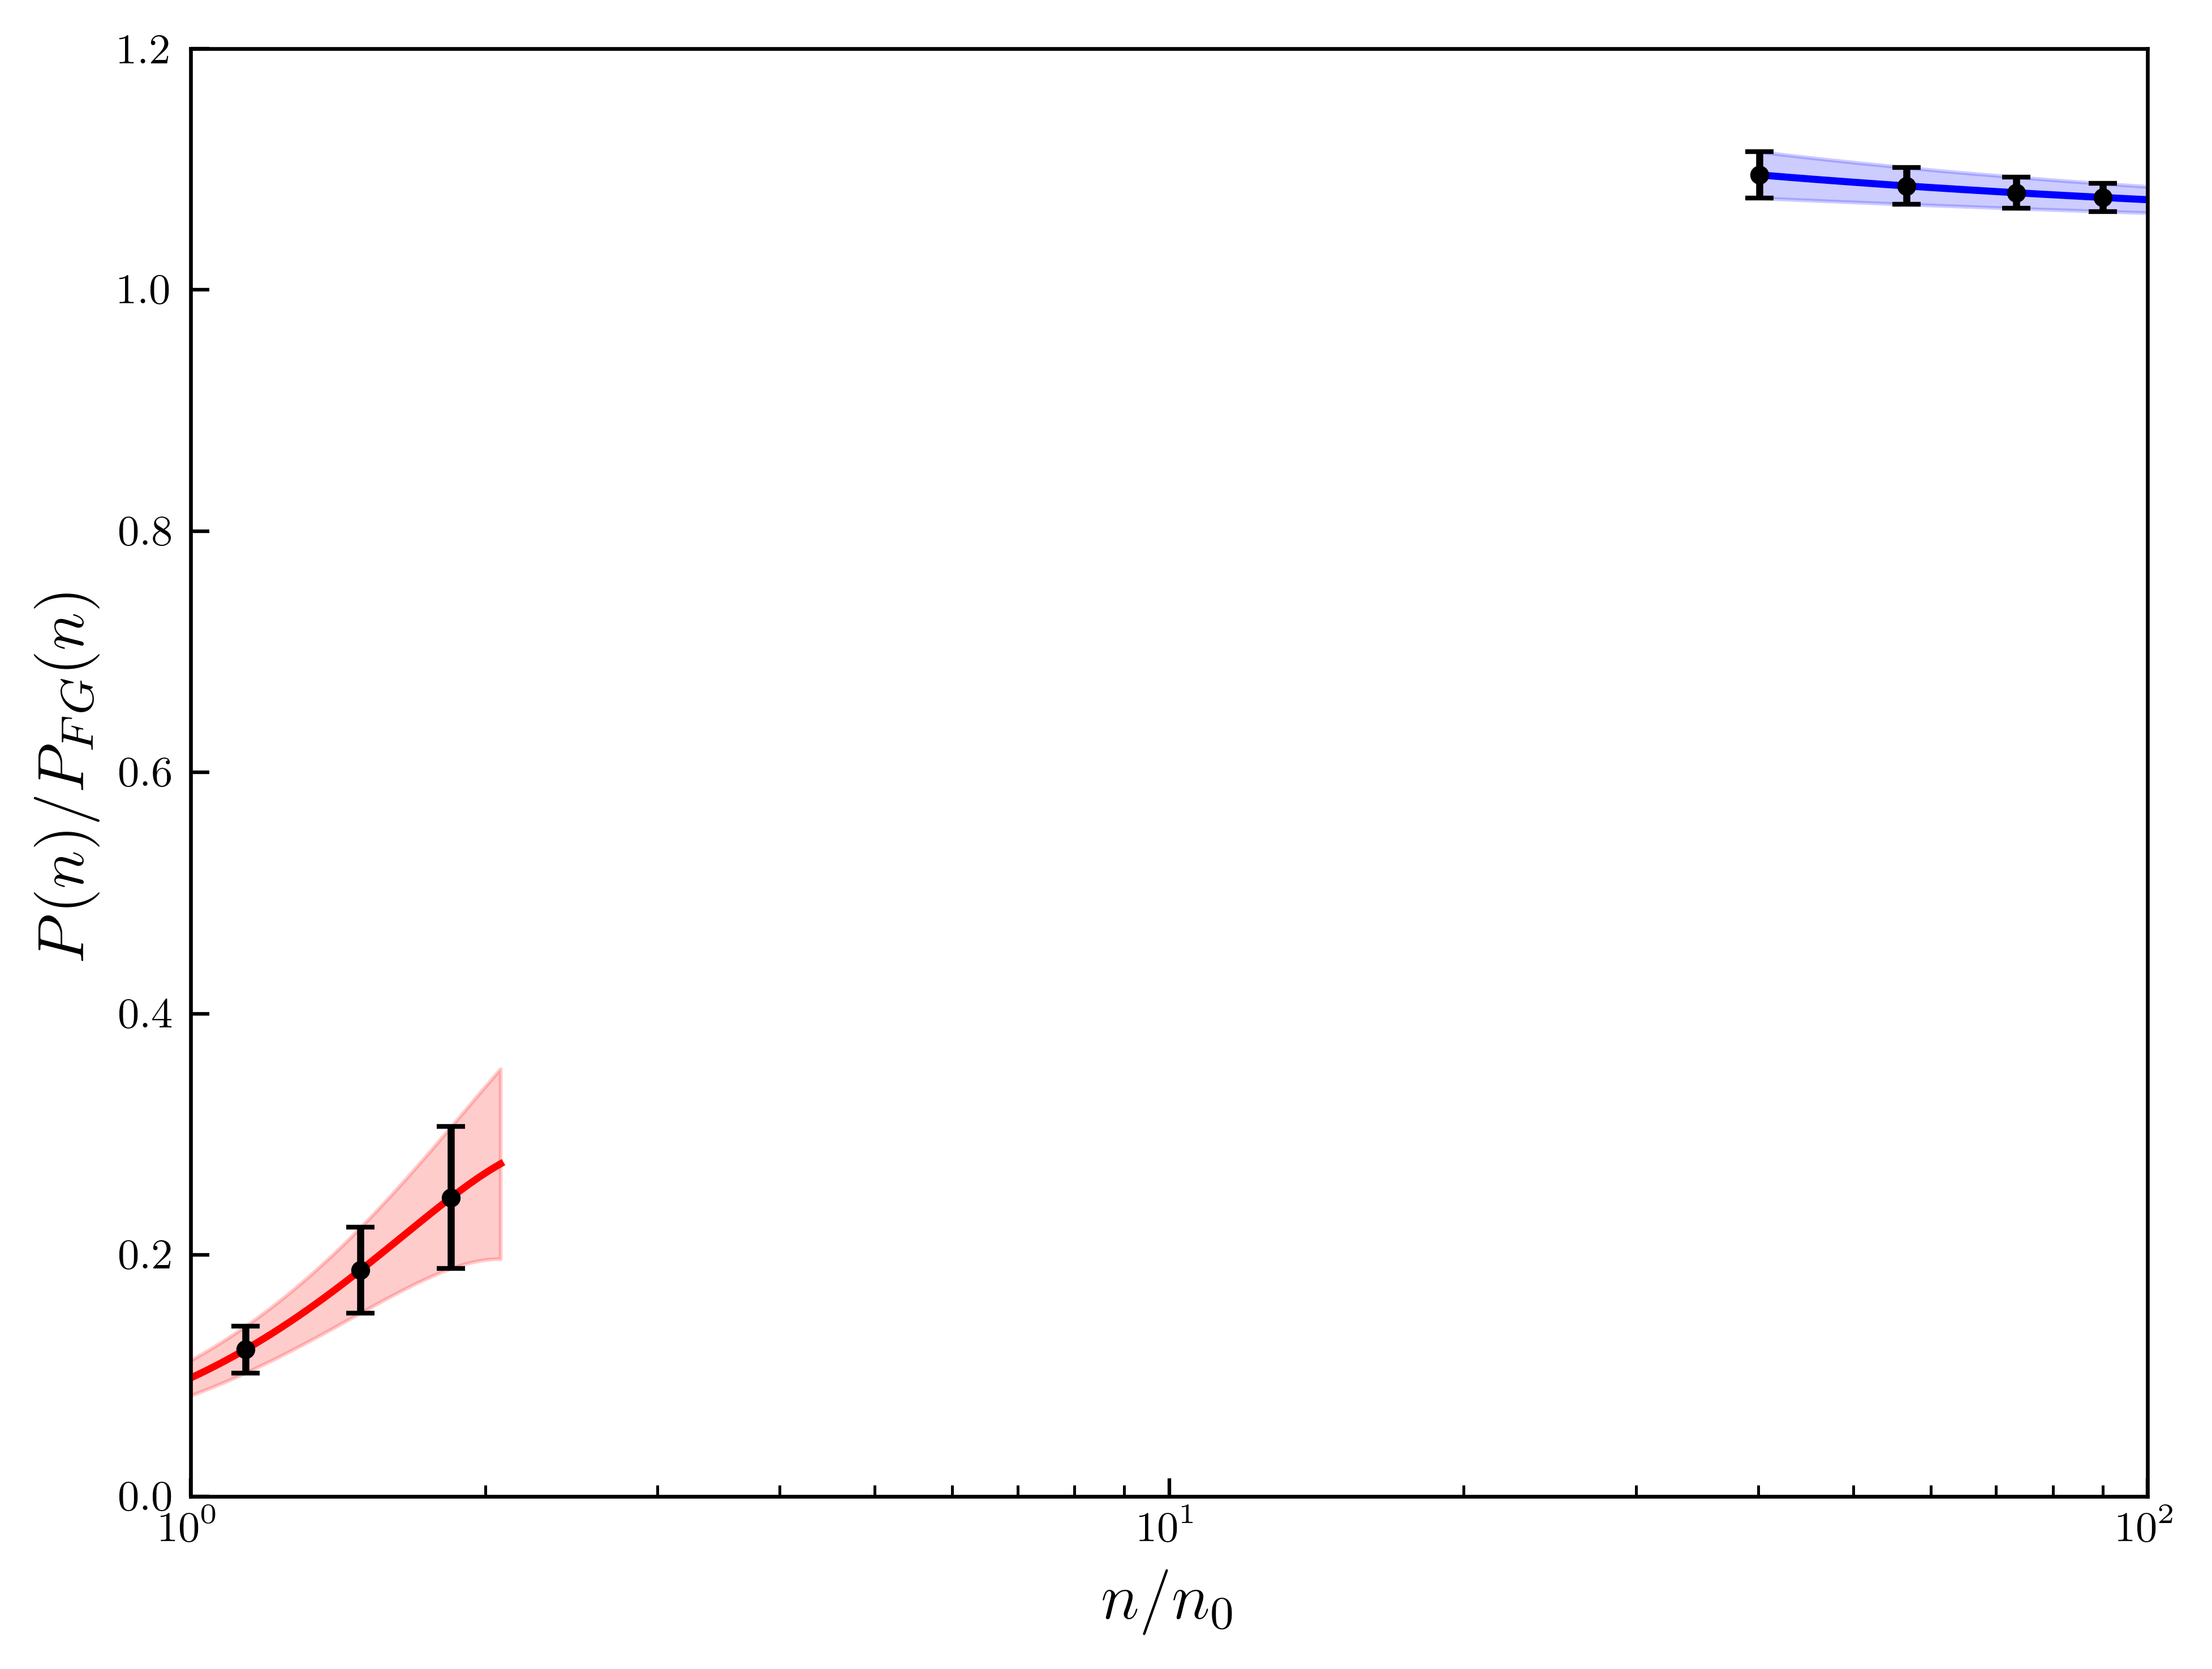

In [10]:
# plot the current data sets
fig, ax = plt.subplots(dpi=600)
ax: Axes
color_xeft = "red"
color_xeft_2 = 'green'
color_pqcd = "blue"
ax.set_xlim(1.0, 100.0)
ax.set_ylim(0, 1.2)
ax.set_xscale('log')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$', fontsize=14)
ax.set_xlabel(r'$n/n_{0}$', fontsize=14)

# result of idea 1
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, \
                alpha=0.2, color=color_xeft)
ax.errorbar(x=training_data['dens']/n0, y=training_data['mean'], yerr=training_data['std'], \
            **errorbar_kwargs)

# result of idea 2
# ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO)')
# ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, \
#                 alpha=0.2, color=color_xeft_2)
# ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
#             **errorbar_kwargs_2)
ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)
#plt.legend()
plt.show()

## Calculation of $P(n)$ using a GP <a id="calc_p_n"></a>

Now we construct the kernel we wish to use, the RBF * constant kernel. Then we will feed this to the `GaussianProcessRegressor2dNoise` function that ties to `sklearn`, and fit to the training data we selected.

We also need to compare the results of the work with the comparison of what happens when I use the same covariance matrix, and fix the lengthscale to reflect the two kernels I see when I work on the RBF kernel with two different covariance matrices.

### Idea 1 training 

In [11]:
# set up the kernel
kernel = C(constant_value=1.1, constant_value_bounds=[0.3,2.25]) * \
RBF(length_scale=0.9, length_scale_bounds=[0.7,1.2])

#constant_value_bounds=[0.3,2.25]) * \
#length_scale_bounds=[0.7, 1.2])  # 40n0 => [0.7,1.2] # 20n0 => 1.1?

X_train = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
y_train = training_data_2['mean'].reshape(-1,1)

# create a small diagonal chicken nugget for the matrix
nugget = 1e-09*np.diag(np.ones(len(training_data_2['cov'])))

# set up the class for the GP
gp = GaussianProcessRegressor2dNoise(
    kernel=kernel,
    alpha=training_data_2['cov'] + nugget,  # here is where we input the full covariance matrix from the data
    n_restarts_optimizer=10000,
)

gp.fit(X_train, y_train, priors=True)  # fit to the data we selected from chiral EFT & pQCD

GaussianProcessRegressor2dNoise(alpha=array([[7.44954453e-05, 1.59815255e-04, 2.65531716e-04, 3.84534049e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.59815255e-04, 3.72888544e-04, 6.64447771e-04, 1.01989478e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.65531716e-04, 6.64447771e-04, 1.25769451e-03, 2.03414616e-03,...
        2.91508480e-04, 2.30909871e-04, 1.96830983e-04, 1.74275189e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.47809527e-04, 1.96830983e-04, 1.68214107e-04, 1.49306828e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.18842202e-04, 1.74275189e-04, 1.49306828e-04, 1.32848049e-04]]),
                                kernel=1.05**2 * RBF(length_scale=0.9),
                                n_restarts_optimizer=10000)

We can print out the kernel hyperparameters ($\bar{c}$ and $\ell$) below, and see what we get using this kernel.

In [12]:
print(gp.kernel_)

0.884**2 * RBF(length_scale=1.15)


### Idea 2 training

In [13]:
# # set up the kernel
# kernel_2 = C(constant_value=0.6) * RBF(length_scale=2.5) #Matern(length_scale=1.5, nu=1.5)

# X_train_2 = np.log(training_data_2['dens']).reshape(-1,1)  # training in the log scale
# y_train_2 = training_data_2['mean'].reshape(-1,1)

# # set up the class for the GP
# gp_2 = GaussianProcessRegressor2dNoise(
#     kernel=kernel_2,
#     alpha=training_data_2['cov']  # here is where we input the full covariance matrix from the data
# )

# gp_2.fit(X_train_2, y_train_2)  # fit to the data we selected from chiral EFT & pQCD

In [14]:
#print(gp_2.kernel_)

We then use the same kernel to predict at new points in density, and plot our GP result.

In [15]:
#conversion for speed of sound
convert_pqcd = np.load('../data/eos_data/pqcd_fg_data_NSM.npz')

# interpolate for a functional form to use 
convert_interp = sp.interpolate.interp1d(convert_pqcd['density'], convert_pqcd['mean'], \
                                 kind='cubic', fill_value='extrapolate')
pqcd_convert_arr = convert_interp(density_test)

In [16]:
# use the testing density array now for predicting at new locations (also in log space)
X = np.log(density_test).reshape(-1,1)
y_pred_1, y_stdv_1 = gp.predict(X, return_std=True)
_, y_cov_1 = gp.predict(X, return_cov=True)

# save for plotting later (uncomment to save)
#np.savez('../data/eos_data/gp_pressure_40.npz', dens=density_test, mean=y_pred, std=y_stdv)

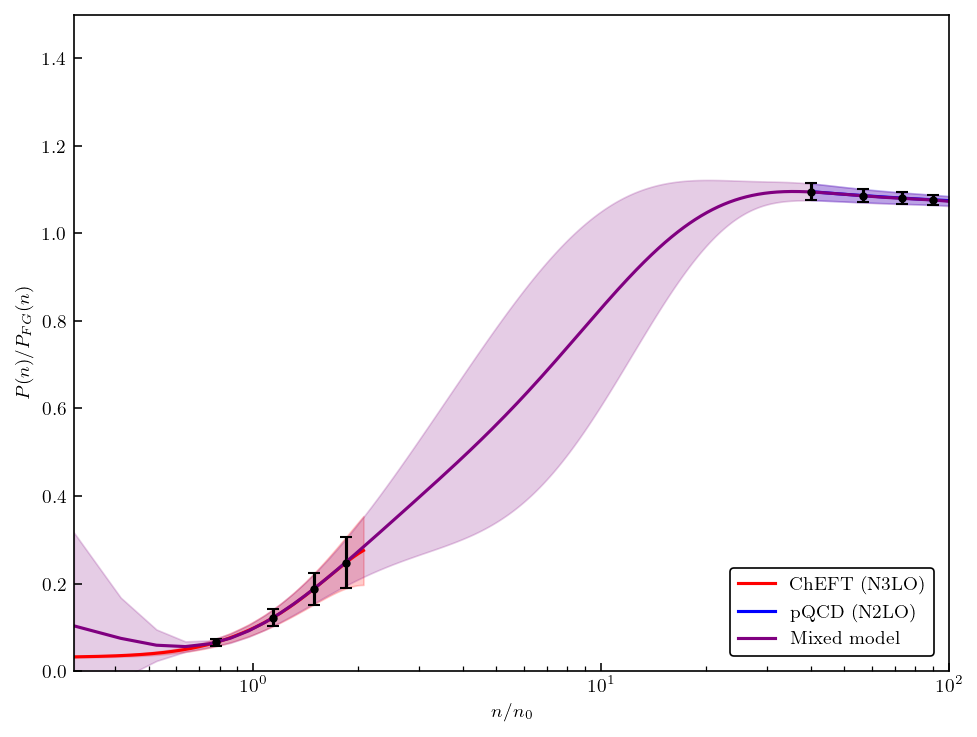

In [17]:
fig, ax = plt.subplots(dpi=150)
ax.set_xlim(min(density_test/n0), 100.0)
ax.set_ylim(0, 1.5)
ax.set_xscale('log') # plot in log base 10
ax.set_xlabel(r'$n/n_{0}$')
ax.set_ylabel(r'$P(n)/P_{FG}(n)$')

# chiral EFT and pQCD curves, training data
ax.plot(n_xeft/n0, p_mean_xeft, color='red', label=r'ChEFT (N3LO)')
ax.fill_between(n_xeft/n0, p_mean_xeft-p_stdv_xeft, p_mean_xeft+p_stdv_xeft, alpha=0.2, \
                color=color_xeft)
ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
            **errorbar_kwargs)

# ax.plot(n_xeft_2/n0, p_mean_xeft_2, color='green', label=r'ChEFT (N3LO) (PNM)')
# ax.fill_between(n_xeft_2/n0, p_mean_xeft_2-p_stdv_xeft_2, p_mean_xeft_2+p_stdv_xeft_2, alpha=0.2, \
#                 color=color_xeft_2)
# ax.errorbar(x=training_data_2['dens']/n0, y=training_data_2['mean'], yerr=training_data_2['std'], \
#             **errorbar_kwargs_2)

ax.plot(n_pqcd/n0, p_mean_pqcd, color='blue', label=r'pQCD (N2LO)')
ax.fill_between(n_pqcd/n0, p_mean_pqcd-p_stdv_pqcd, p_mean_pqcd+p_stdv_pqcd, alpha=0.2, color=color_pqcd)

# GP result and uncertainty band
ax.plot(density_test/n0, y_pred_1, c='purple', label=r'Mixed model')
ax.fill_between(density_test/n0, y_pred_1-y_stdv_1, y_pred_1+y_stdv_1, color="purple", alpha=0.2)

# ax.plot(density_test/n0, y_pred_2, c='grey', label=r'Mixed model (PNM)')
# ax.fill_between(density_test/n0, y_pred_2-y_stdv_2, y_pred_2+y_stdv_2, color="grey", alpha=0.3)

# import contours and plot
#df = pd.read_csv('../data/contour_scaled.csv')
#df_frg = pd.read_csv('../data/frg_data_pressure.csv')

# unscale FRG
#ax.plot(df['Density/n0'], df['p_pfg'], color='k', linestyle='dashdot', label='HIC data')
#ax.plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', label='FRG contour')

plt.legend(loc='lower right')
#fig.savefig('../figures/RBF_comparison_cov.png')
plt.show()

In [18]:
# print the covariance matrix
print(y_cov_1)  # oof, it is not positive semi-definite, very true!

[[4.55199603e-02 1.96303429e-02 7.37411122e-03 ... 4.86915435e-05
  4.92346453e-05 4.97821515e-05]
 [1.96303429e-02 8.65937443e-03 3.31069767e-03 ... 2.33645953e-05
  2.36213164e-05 2.38801277e-05]
 [7.37411122e-03 3.31069767e-03 1.28891533e-03 ... 9.66052693e-06
  9.76550092e-06 9.87133197e-06]
 ...
 [4.86915435e-05 2.33645953e-05 9.66052693e-06 ... 1.19492014e-04
  1.19447521e-04 1.19403398e-04]
 [4.92346453e-05 2.36213164e-05 9.76550092e-06 ... 1.19447521e-04
  1.19403727e-04 1.19360307e-04]
 [4.97821515e-05 2.38801277e-05 9.87133197e-06 ... 1.19403398e-04
  1.19360307e-04 1.19317595e-04]]


---

## Speed of sound calculation, $c_{s}^{2}(n)$ <a id="calc_cs2"></a>

We need to extract the speed of sound from the pressure equation. The most direct way to do this is to integrate the $P(n)$ curve to get the energy density, as we did as well in the pointwise mixing notebook. 

$$
P(n) = n^{2} \frac{\partial (\varepsilon/n)}{\partial n}
$$

$$
\varepsilon(n) = n \left[\int_{n}^{n_{i}} \frac{P(n)}{n^{2}} dn + \frac{\varepsilon(n_{i})}{n_{i}} \right],
$$

where $n_{i}$ is 16.4 fm$^{-3}$, as we will be integrating downwards from pQCD to $\chi$EFT in this approach.

After we achieve the energy density in this manner, we will then code the chemical potential as

$$
\mu(n) = \frac{P(n) + \varepsilon(n)}{n},
$$

and finally obtain the speed of sound, given as

$$
c_{s}^{2}(n) = \frac{\partial P}{\partial n } / \frac{\partial \varepsilon}{\partial n} = \frac{1}{\mu(n)} \frac{\partial P(n)}{\partial n}.
$$

We have a utility function that runs both the integration and the speed of sound calculation, so we will call that and implement the speed of sound. However, we first need to sample from the GP, since this is the way to best propagate the uncertainties from the pressure to the speed of sound without drastically overestimating them.

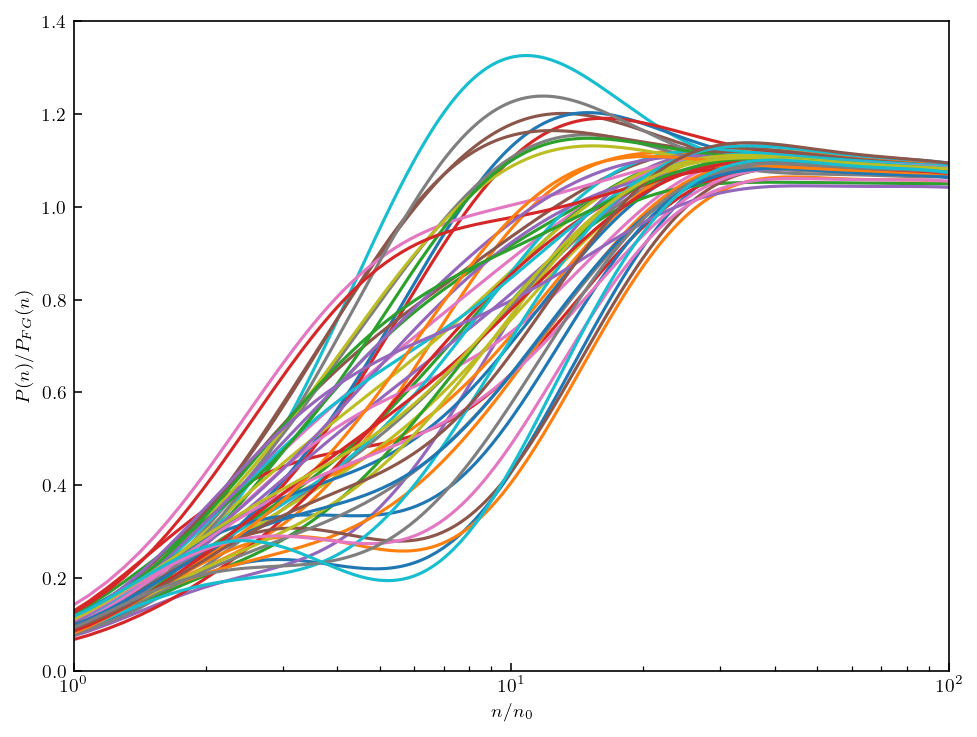

In [46]:
# sample from the pressure GP curve first (we'll need a LOT...)
samples = 50
samples_data = gp.sample_y(X=np.log(density_test.reshape(-1,1)), n_samples=samples)

# plot the samples to test the validity of the call
plt.plot(density_test/n0, samples_data)
plt.xlim(1.0, 100.0)
plt.ylim(0.0, 1.4)
plt.xscale('log')
plt.ylabel(r'$P(n)/P_{FG}(n)$')
plt.xlabel(r'$n/n_{0}$')
plt.show()

Hello, here:  (899, 11)


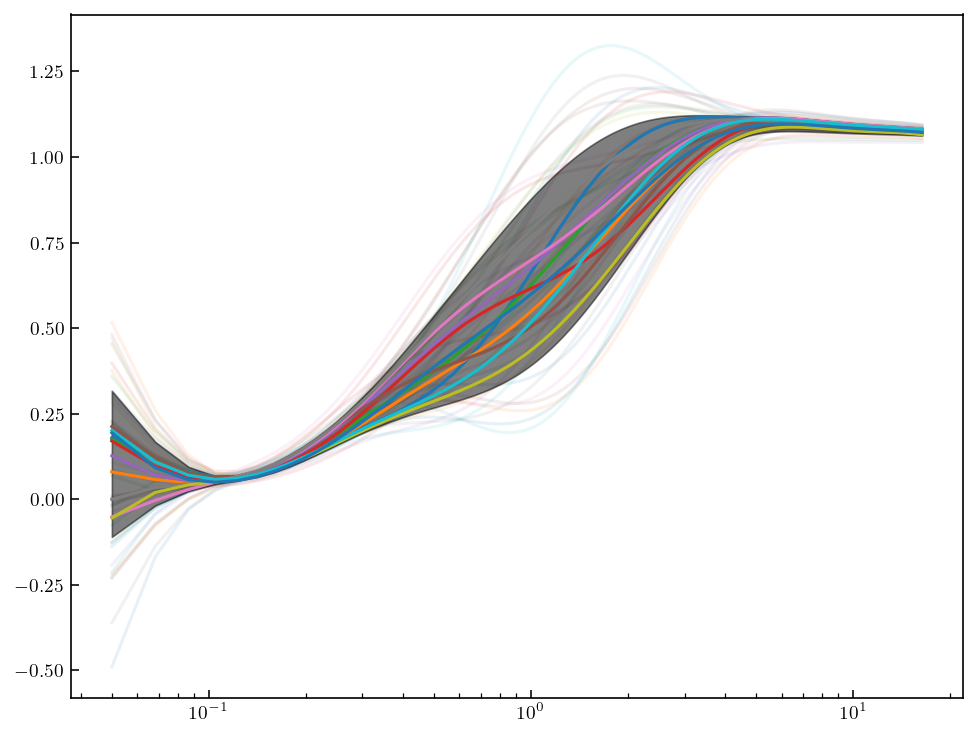

(899, 50)
(899, 50)


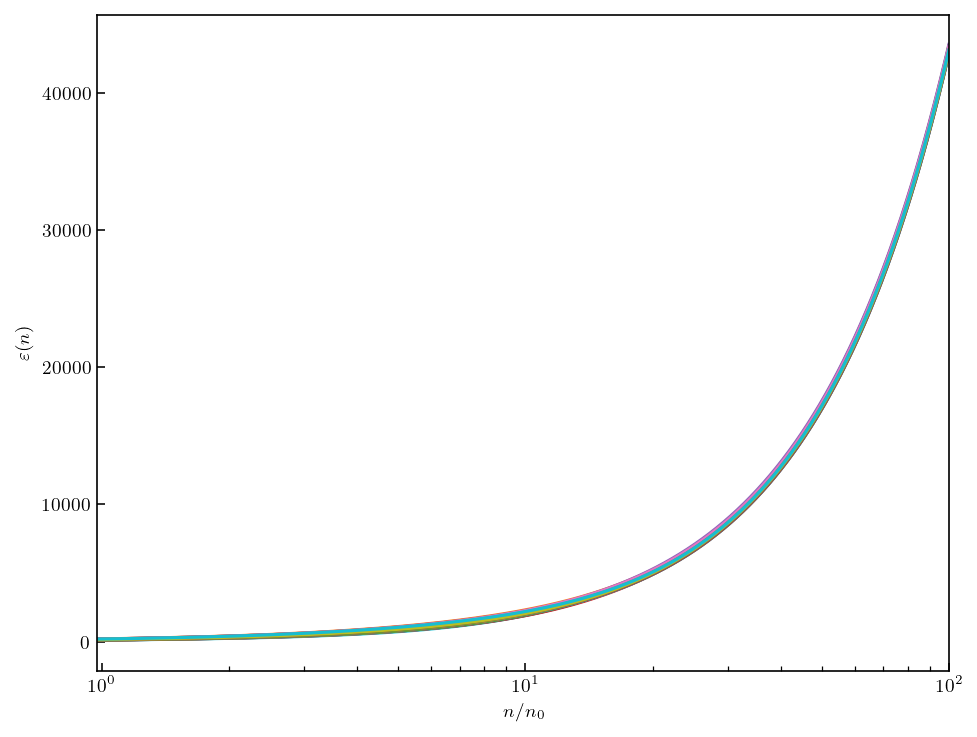

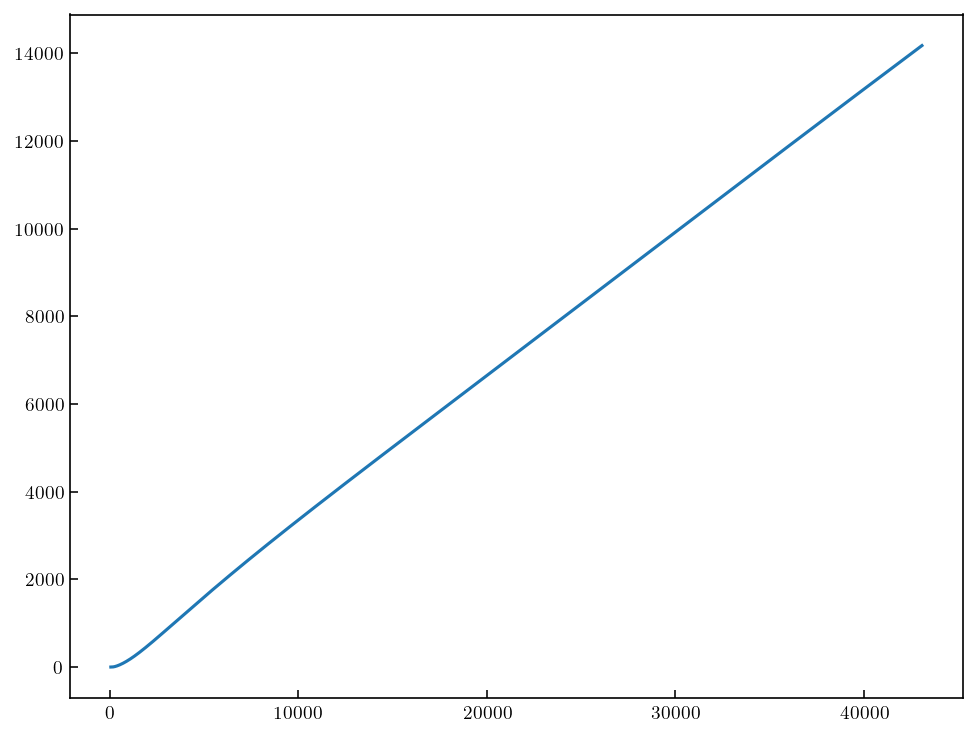

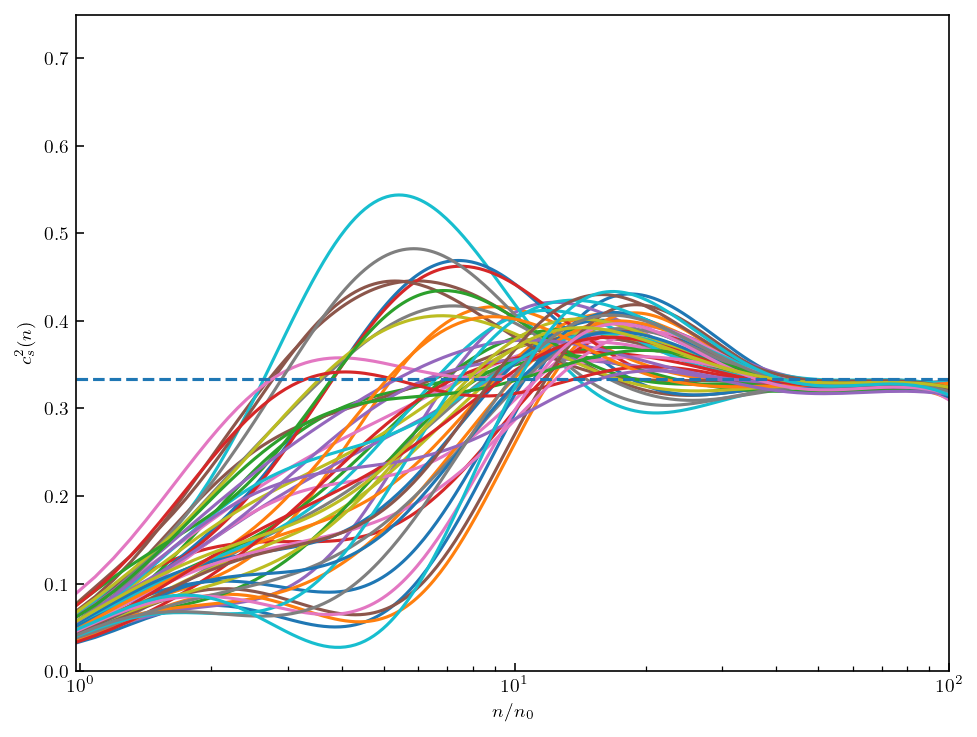

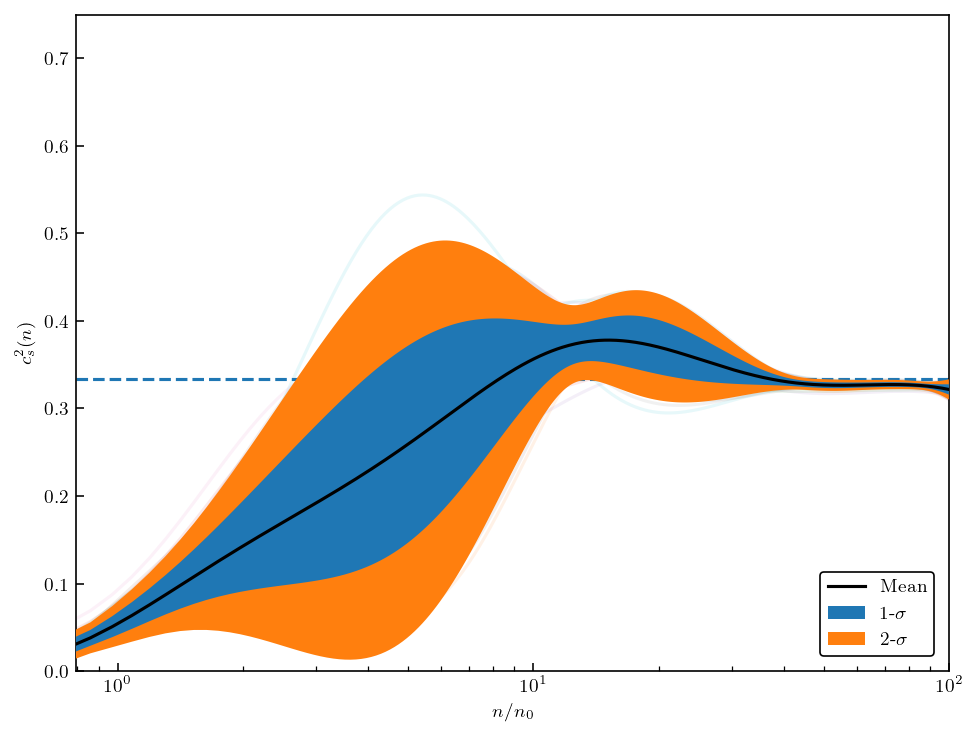

In [47]:
# integrate backward to anchor at pQCD and plot the speed of sound result
pres_samples = samples_data  

# run interpolation for FG scaling (needed for determination 
# of P(n) from scaled result)
gp_cs2_convert_arr = convert_interp(density_test)

# unscale the samples from the FG scaling
pres_samples_unscaled = [pres_samples[:,i]*gp_cs2_convert_arr \
                         for i in range(len(np.asarray(pres_samples).T))]

# cut at saturation (or thereabouts; unstable matter under saturation for symmetric)
sat_cut = 0 #(np.where([i >= 0.164 for i in density_test])[0][0]) - 1

# pull dict values out and make arrays
gp_mean = y_pred_1
gp_std = y_stdv_1

# send to the speed of sound calculation (for interpolation)
pres_dict = {
    'mean': gp_mean[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'std_dev': gp_std[sat_cut:]*gp_cs2_convert_arr[sat_cut:],
    'samples': np.asarray(pres_samples_unscaled)[:, sat_cut:].T
}

# here select the curves that are within the 68% envelope
from eos_utils import select_draws
reduced_samples = select_draws(pres_dict)
print('Hello, here: ', reduced_samples.shape)  # --> how is this one?

# print the total draws underneath the ones selected
[plt.plot(density_test[sat_cut:], pres_samples[:,j],alpha=0.1, zorder=-5) for j in range(len(pres_samples.T))]
[plt.plot(density_test[sat_cut:], reduced_samples[:,j]/gp_cs2_convert_arr[sat_cut:], zorder=20) \
 for j in range(len(reduced_samples.T))]
plt.fill_between(density_test[sat_cut:], (pres_dict['mean']-pres_dict['std_dev'])/\
                 gp_cs2_convert_arr[sat_cut:], \
                 (pres_dict['mean']+pres_dict['std_dev'])/gp_cs2_convert_arr[sat_cut:], \
                 color='black', alpha=0.5, zorder=10)
plt.xscale('log')
plt.show()

# integrating downwards from pQCD
# (results here from pQCD notebook boundary_conditions function)
en_0 = 43656.4556069574
en_0_lower = 43510.21143367375
en_0_upper = 43797.873283570414

# for draws, try new anchor point function
pqcd_class = PQCD(X=1, Nf=3)
edens_0_draw_arr = pqcd_class.anchor_point_edens(np.asarray(pres_samples_unscaled)[:, sat_cut:].T, \
                                                 anchor=density_test[-1])

# make dict of values to send to speed of sound code
edens_dict = {
    'mean': en_0, 
    'lower': en_0_lower,
    'upper': en_0_upper,
    'samples': edens_0_draw_arr
}

# call speed of sound function (sampled = True automatically runs the integration downwards)
cs2_sampled, edens_full = speed_of_sound(density_test[sat_cut:], pres_dict, \
                                         edens_dict, sat=False, sampled=True)

# energy density
[plt.plot(density_test[sat_cut:]/n0, edens_full[i]) for i in range(len(edens_full))]
#print(density_test[sat_cut:])
#plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$\varepsilon(n)$')
plt.xlim(0.16/n0, 16.4/n0)
plt.xscale('log')
plt.show()

# get mean and std_dev for edens to plot P(eps) for shits and giggles
edens_mean = np.nanmean(edens_full, axis=0)
edens_std = np.nanstd(edens_full, axis=0)

# plot the pressure vs. energy density
plt.plot(edens_mean, pres_dict['mean'])
plt.show()

# save for plotting later (uncomment to save)
# np.savez('../data/eos_data/cs2_gp_40.npz', dens=density_test[sat_cut:], mean=cs2_log['mean'],\
#          std=cs2_log['std'], samples=cs2_log['samples'])

# dict entries 
cs2_sampled_mean = cs2_sampled['mean']
cs2_sampled_std = cs2_sampled['std']
cs2_sampled_samples = cs2_sampled['samples']

# samples plot
[plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i]) for i in range(len(edens_full))]
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.16/n0, 16.4/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.show()

# mean and std dev band plot
[plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i], alpha=0.1) for i in range(len(edens_full))]
plt.plot(density_test[sat_cut:]/n0, cs2_sampled_mean, 'k', zorder=20, label=r'Mean')
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_sampled_mean-cs2_sampled_std, cs2_sampled_mean+cs2_sampled_std, zorder=12, \
                 label=r'1-$\sigma$')
plt.fill_between(density_test[sat_cut:]/n0, \
                 cs2_sampled_mean-1.96*cs2_sampled_std, cs2_sampled_mean+1.96*cs2_sampled_std, \
                 label=r'2-$\sigma$', zorder=10)
plt.axhline(y=1.0/3.0, linestyle='dashed')
plt.xlabel(r'$n/n_{0}$')
plt.ylabel(r'$c_{s}^{2}(n)$')
plt.xlim(0.13/n0, 16.4/n0)
plt.xscale('log')
plt.ylim(0.0, 0.75)
plt.legend(loc='lower right')
plt.show()

# for the next plot
cs2_sampled_draws = cs2_sampled

# save the dict in case anything bad happens...
#np.savez('cs2_backup_samples.npz', density=density_test[sat_cut:], cs2_samples=cs2_sampled['samples'])

In [48]:
# # make dict of values to send to speed of sound code
# edens_dict = {
#     'mean': en_0, 
#     'lower': en_0_lower,
#     'upper': en_0_upper,
# }

# # call speed of sound function (sampled = True automatically runs the integration downwards)
# cs2_sampled, edens_full = speed_of_sound(density_test[sat_cut:], pres_dict, \
#                                          edens_dict, sat=False, sampled=True)

# # get mean and std_dev for edens to plot P(eps) for shits and giggles
# edens_mean = np.nanmean(edens_full, axis=0)
# edens_std = np.nanstd(edens_full, axis=0)

# # dict entries 
# cs2_sampled_mean = cs2_sampled['mean']
# cs2_sampled_std = cs2_sampled['std']
# cs2_sampled_samples = cs2_sampled['samples']

# # use old ones too and compare
# cs2_sampled_draws_mean = cs2_sampled_draws['mean']
# cs2_sampled_draws_std = cs2_sampled_draws['std']
# cs2_sampled_draws_samples = cs2_sampled_draws['samples']

# # mean and std dev band plot
# [plt.plot(density_test[sat_cut:]/n0, cs2_sampled_samples[i], alpha=0.1) for i in range(len(edens_full))]
# plt.plot(density_test[sat_cut:]/n0, cs2_sampled_mean, 'k', zorder=20, label=r'Mean')
# plt.fill_between(density_test[sat_cut:]/n0, \
#                  cs2_sampled_mean-cs2_sampled_std, cs2_sampled_mean+cs2_sampled_std, zorder=12, \
#                  label=r'1-$\sigma$', alpha=0.5)
# plt.fill_between(density_test[sat_cut:]/n0, \
#                  cs2_sampled_mean-1.96*cs2_sampled_std, cs2_sampled_mean+1.96*cs2_sampled_std, \
#                  label=r'2-$\sigma$', zorder=10, alpha=0.5)
# # draws as well
# [plt.plot(density_test[sat_cut:]/n0, cs2_sampled_draws_samples[i], alpha=0.1) for i in range(len(edens_full))]
# plt.plot(density_test[sat_cut:]/n0, cs2_sampled_draws_mean, 'k', linestyle='dashed', zorder=20, label=r'Mean (Draws)')
# plt.fill_between(density_test[sat_cut:]/n0, \
#                  cs2_sampled_draws_mean-cs2_sampled_draws_std, cs2_sampled_draws_mean+cs2_sampled_draws_std, zorder=12, \
#                  label=r'1-$\sigma$ (Draws)', alpha=0.3)
# plt.fill_between(density_test[sat_cut:]/n0, \
#                  cs2_sampled_draws_mean-1.96*cs2_sampled_draws_std, cs2_sampled_draws_mean+1.96*cs2_sampled_draws_std, \
#                  label=r'2-$\sigma$ (Draws)', zorder=10, alpha=0.3)
# plt.axhline(y=1.0/3.0, linestyle='dashed')
# plt.xlabel(r'$n/n_{0}$')
# plt.ylabel(r'$c_{s}^{2}(n)$')
# plt.xlim(0.13/n0, 16.4/n0)
# plt.xscale('log')
# plt.ylim(0.0, 0.75)
# plt.legend(loc='lower right')
# plt.show()

In [49]:
# print(pres_samples.shape)
# print(np.asarray(edens_full).T.shape)

# organize the samples into the correct pairing (same style as a file would be)
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# turn edens_full into an array
edens = np.asarray(edens_full).T

# save data in dat file backwards (without cs2 to start)
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens[tov_index:]
gp_final = np.asarray([pres_samples[tov_index:, i]*\
                       convert_interp(density_test[tov_index:]) for i in range(samples)]).T
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(samples)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(samples)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final)).reshape(-1,1)
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
np.savez("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_test.npz", density=dens_tov, \
        edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

In [50]:
# run the TOV solver over each sample (very janky for now)
import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver
mass_data = np.zeros([50,samples])
radius_data = np.zeros([50,samples])
pressure_data = np.zeros([50,samples])

# call the solver once, send all data directly
tov = TOVsolver(eos_filepath='../../../FASTAR/TOV/Alexandra_TOV/eos_tov_test.npz')

# call routine once (should do its thing...check why central pressures are the same for different ones)
radius_data, pressure_data, mass_data = tov.tov_routine(verbose=False)

Woo it worked!
Radius:  5.368388317869451 Maximum mass:  0.8693793267315569 Central pressure:  2200.721894819905
Radius:  9.13722507377652 Maximum mass:  1.5175339230015243 Central pressure:  636.240764772628
Radius:  10.82906967682636 Maximum mass:  1.7471861917606166 Central pressure:  342.0973067434033
Radius:  10.570907856103311 Maximum mass:  1.2310789674773845 Central pressure:  183.94069314768447
Radius:  7.352715002626026 Maximum mass:  1.217961050590585 Central pressure:  1013.2704295883759
Radius:  12.940822447353753 Maximum mass:  2.292856341610851 Central pressure:  292.9420362292324
Radius:  11.119807448566926 Maximum mass:  1.6814893434142257 Central pressure:  292.9420362292324
Radius:  8.70509432505409 Maximum mass:  1.317512970473454 Central pressure:  544.8206153354404
Radius:  8.693138216769917 Maximum mass:  1.2790958913196697 Central pressure:  544.8206153354404
Radius:  12.63530639954799 Maximum mass:  2.396958773050684 Central pressure:  399.5007639993038
Radius:

In [51]:
# save the radius, central pressure, and mass data to a file in case want to use later
np.savez('rad_mass_central.npz', radius=radius_data, mass=mass_data, pres_central=pressure_data)

In [52]:
# # mean and envelope version now (add to the plot)

# # now work with the mean and std of pressure, energy density (envelope calculation)
edens_lower = edens_mean - edens_std
edens_higher = edens_mean + edens_std
pres_lower = gp_mean - gp_std
pres_higher = gp_mean + gp_std
gp_res = np.column_stack([pres_lower, gp_mean, pres_higher])

# concatenate into "samples"
edens_envelope = np.column_stack([edens_lower, edens_mean, edens_higher])

# save data in dat file backwards
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_envelope[tov_index:]
gp_final = np.asarray([gp_res[tov_index:, i]*\
                       convert_interp(density_test[tov_index:]) for i in range(3)]).T
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.asarray([np.concatenate((low_den_file[::-1,0], edens_final[:,i])) for i in range(3)]).T
pres_tov = np.asarray([np.concatenate((low_den_file[::-1,1], gp_final[:,i])) for i in range(3)]).T
dens_tov = np.concatenate((low_den_file[::-1,2], density_final)).reshape(-1,1)
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
#np.savez("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_env_test.npz", density=dens_tov, edens=edens_tov, pres=pres_tov, cs2=cs2_tov)

In [53]:
# run the TOV solver over each sample (very janky for now) -> what's up here rn...? weird crossings?
# mass_data_env = np.zeros([50,3])
# radius_data_env = np.zeros([50,3])
# pressure_data_env = np.zeros([50,3])

# # call solver once, call routine once
# tov_env = TOVsolver(eos_filepath="../../../FASTAR/TOV/Alexandra_TOV/eos_tov_env_test.npz")
# radius_data_env, pressure_data_env, mass_data_env = tov_env.tov_routine(verbose=False)

One sigma band at max mass: 1.4956754686065767 +/- 0.4255647307452258, aka 1.0701107378613508 - 1.9212401993518027


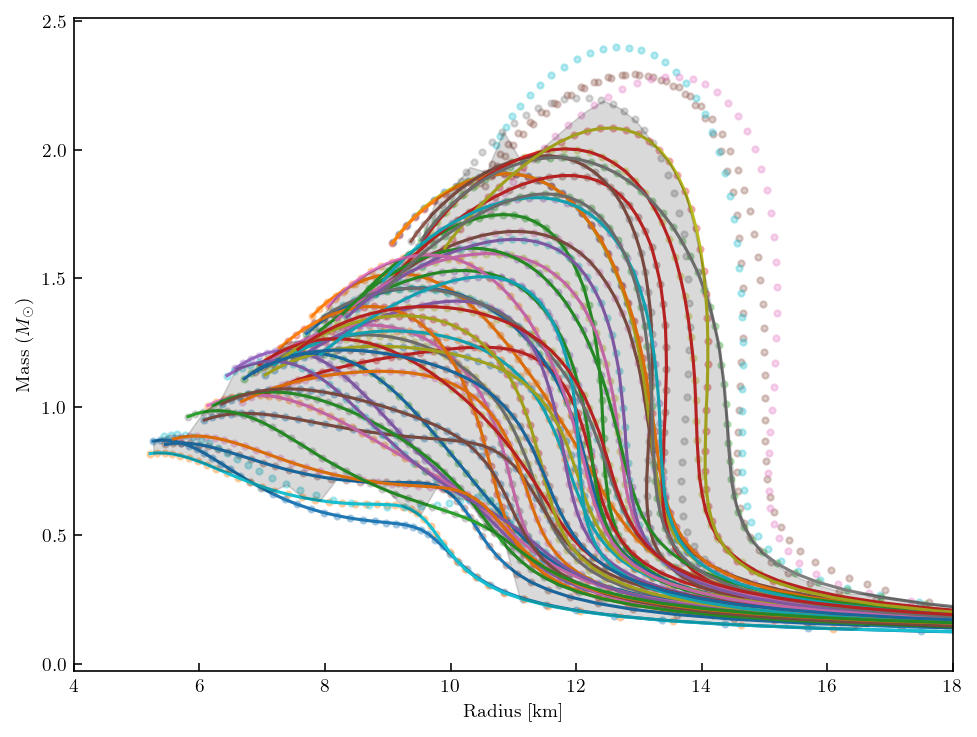

In [57]:
# calculate the mean and std_dev from this plot 
# (use max mass to find the nearest value to the mean, see how that works...)
max_masses = []
for i in range(len(mass_data.T)):
    max_masses.append(max(mass_data[:,i]))

# convert to array and find the mean
max_masses_arr = np.asarray(max_masses)
mean_tov = np.nanmean(max_masses_arr, axis=0)
std_tov = np.nanstd(max_masses_arr, axis=0)
#print(mean_tov) # whoa it actually is equivalent to the GP one...but the bands are crossing for UQ then...
#print(std_tov)  # max mass std dev here, not the full curve
print('One sigma band at max mass: {} +/- {}, aka {} - {}'.format(mean_tov, \
                                                                  std_tov, mean_tov-std_tov, \
                                                                  mean_tov+std_tov))

# calculate the intervals (way #1)
new_rad, mean_mass, std_mass, interpd_mass, median_mass = tov.interval_einfach()

# calculate the intervals (way #2)
new_rad_2, hpd_interval = tov.interval_schwer(fraction=0.90)
new_rad_3, hpd_interval_2 = tov.interval_schwer(fraction=0.68)

# now interpolate the intervals
reduced_radius_curves, reduced_mass_curves = tov.select_curves(new_rad_2, hpd_interval)

# plot the results including the samples and the overall mean, std_dev
[plt.plot(radius_data[:,i], mass_data[:,i], '.', alpha=0.3) for i in range(samples)]
#[plt.plot(new_rad, interpd_mass[:,j]) for j in range(samples)]
#plt.fill_between(new_rad, mean_mass-std_mass, mean_mass+std_mass, alpha=0.2)
#plt.plot(new_rad[5:], median_mass[5:], 'r', zorder=22)
plt.fill_between(new_rad_2, hpd_interval[:,0], hpd_interval[:,1], color='black', alpha=0.15, zorder=10)
#plt.fill_between(new_rad_3, hpd_interval_2[:,0], hpd_interval_2[:,1], color='blue', alpha=0.35, zorder=11)
[plt.plot(reduced_radius_curves[:,i], reduced_mass_curves[:,i]) for i in range(len(reduced_radius_curves.T))]
# plt.plot(radius_data_env[:,1], mass_data_env[:,1], 'k')
plt.xlim(4.0, 18.0)
plt.xlabel(r'Radius [km]')
plt.ylabel(r'Mass $(M_\odot)$')
plt.show()

---

In [74]:
# import the speed of sound data from ChEFT and pQCD
cs2_chiral = np.load('../data/NSM_data/cs2_chiral_NSM.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_NSM.npz')  # --> are we using the correct result here?

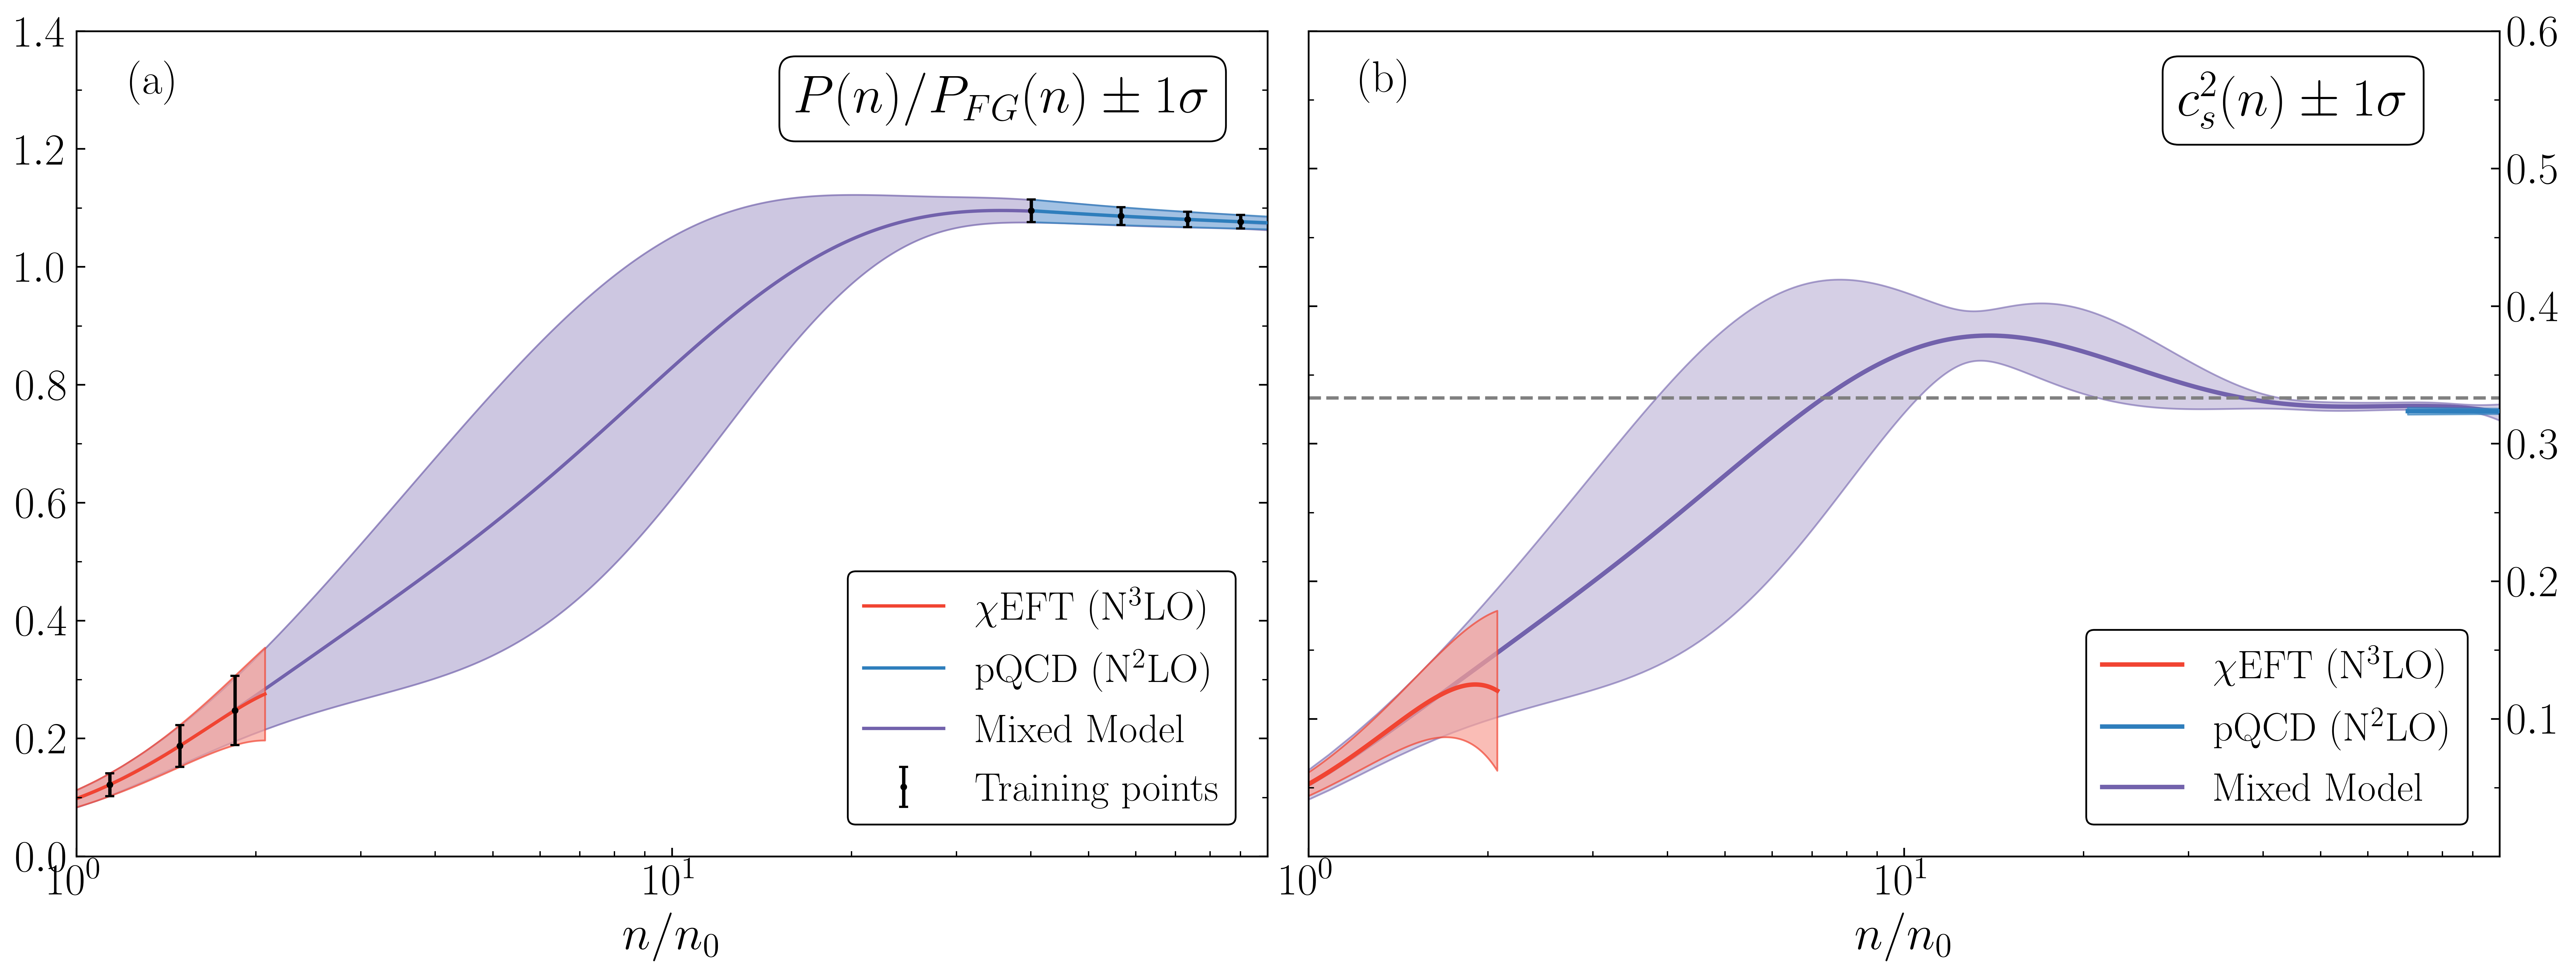

In [75]:
import pandas as pd
# set up the plot requirements
fig, ax = plt.subplots(1, 2, figsize=(16,6), dpi=600, sharex='col')
#fig.patch.set_alpha(0.0)
ax[0].set_xlim(1.00, max(density_test/n0))
ax[0].set_ylim(0.0,1.4)
ax[0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0].xaxis.set_major_locator(MultipleLocator(10))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0].text(1.5, 1.35, r'(a)', ha='right', va='top', fontsize=20)
ax[0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[0].set_xscale('log')

ax[1].set_xlim(1., max(density_test/n0))
ax[1].set_ylim(1e-6,0.6)
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1].text(1.5, 0.58, r'(b)', ha='right', va='top', fontsize=20)
ax[1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1].set_xscale('log')

orders = [0,1,2]

# plotting assistance
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use
mean_chiral = data_xeft['mean']
mean_pqcd = data_pqcd['mean'][:,2]
std_dev_chiral = data_xeft['std_dev']
std_dev_pqcd = data_pqcd['std_dev'][:,2]

# pressure data

# model means and uncertainties
ax[0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0].fill_between(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:] - \
                   1.0*std_dev_pqcd[ind_cut:], mean_pqcd[ind_cut:] + 1.0*std_dev_pqcd[ind_cut:], \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0].plot(data_pqcd['density'][ind_cut:]/n0, mean_pqcd[ind_cut:], zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0].fill_between(density_test/n0, gp_mean-1.0*gp_std, gp_mean+ \
                   1.0*gp_std,
                       zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0].plot(density_test/n0, gp_mean, color=colors[2], zorder=-1, label='Mixed Model')
  
# plot the training points
ax[0].errorbar(training_data["dens"]/n0, training_data["mean"], yerr=training_data["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0].legend(loc='lower right', facecolor='w', fontsize=18)

# speed of sound data 
ax[1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean']+cs2_chiral['std'], \
                 cs2_chiral['mean']-cs2_chiral['std'], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
plt.plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
plt.fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1].fill_between(density_test[sat_cut:]/n0, cs2_sampled['mean']-cs2_sampled['std'], \
                   cs2_sampled['mean']+cs2_sampled['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1].plot(density_test[sat_cut:]/n0, cs2_sampled['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1].legend(loc='lower right', facecolor='w', fontsize=18)
plt.show()
#fig.savefig('subplot_curvewise_model_40n0.PNG', bbox_inches='tight')

---

## Saving EOS data for the TOV solver

In [70]:
# append the low density data to these arrays when reversed
low_den_file = np.loadtxt("../data/NSM_data/MFT_ns6p.dat", skiprows=1)

# save data in dat file backwards (without cs2 to start)
tov_index = (np.where([density_test[i] <= 0.08 for i in range(len(density_test))])[0][-1] + 1)
edens_final = edens_mean[tov_index:]
gp_final = gp_mean[tov_index:]*convert_interp(density_test[tov_index:])
density_final = density_test[tov_index:]

# run through and append the low density data to these arrays and then save to file
edens_tov = np.concatenate((low_den_file[::-1,0], edens_final))
pres_tov = np.concatenate((low_den_file[::-1,1], gp_final))
dens_tov = np.concatenate((low_den_file[::-1,2], density_final))
cs2_tov = np.zeros(len(density_final) + len(low_den_file[:,0]))

# end result of file needed
tov_data = np.column_stack([edens_tov, pres_tov, dens_tov, cs2_tov])
np.savetxt("../../../FASTAR/TOV/Alexandra_TOV/eos_tov_40n0.dat", tov_data)

# try saving to an npz file instead
np.savez('../../../FASTAR/TOV/Alexandra_TOV/eos_zip_test.npz', density=dens_tov, edens=edens_tov, pres=pres_tov, cs2 = cs2_tov)

In [71]:
# try running the solver class object for the npz file format and txt file format
import sys
sys.path.append('../../../TOV_Solver/')
from TOV_class import TOVsolver
tov = TOVsolver(eos_filepath='../../../FASTAR/TOV/Alexandra_TOV/eos_zip_test.npz')

# try running for the single sample and see what happens
max_radius, max_pres_central, max_mass = tov.tov_routine(verbose=False)

Woo it worked!
Radius:  9.453070236289815 Maximum mass:  1.4143352649354075


---

---

## Creating the multi-plot figure in the paper

Below is the code we used to generate the 4 panel figure in our paper. 

In [21]:
# Fig. 8 in our paper

# load in each file of results needed for P(n)
data_xeft = np.load('../data/eos_data/pressure_chiral_data_scaled_2n0.npz')
data_pqcd = np.load('../data/eos_data/pressure_pqcd_cut_20.npz')
data_pqcd_40 = np.load('../data/eos_data/pressure_pqcd_cut_40.npz')
df = pd.read_csv('../data/contour_scaled.csv')
df_frg = pd.read_csv('../data/frg_data_pressure.csv')
training_data_20 = np.load('../data/eos_data/correlated_training_data_20n0.npz')
training_data_40 = np.load('../data/eos_data/correlated_training_data_40n0.npz')
pressure_gp_20 = np.load('../data/eos_data/gp_pressure_20.npz')
pressure_gp_40 = np.load('../data/eos_data/gp_pressure_40.npz')

# load in each file of results need for cs2(n)
cs2_chiral = np.load('../data/eos_data/speedofsoundchiral.npz')
cs2_pqcd = np.load('../data/eos_data/pqcd_cs2_11.2.npz')
cs2_GP_20 = np.load('../data/eos_data/cs2_gp_20.npz')
cs2_GP_40 = np.load('../data/eos_data/cs2_gp_40.npz')

# set up the orders and labels
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

# assign means and std devs for easier use for chiral, pqcd data
dens_pqcd = data_pqcd['dens']
dens_pqcd_40 = data_pqcd_40['dens']
mean_chiral = data_xeft['mean'][:,3]
mean_pqcd = data_pqcd['mean']
mean_pqcd_40 = data_pqcd_40['mean']
std_dev_chiral = data_xeft['std_dev'][:,3]
std_dev_pqcd = data_pqcd['std']
std_dev_pqcd_40 = data_pqcd_40['std']

In [22]:
# now we need to create the skeleton of the figure
fig, ax = plt.subplots(2, 2, figsize=(16,12), dpi=600, sharex='col')

# first row
ax[0,0].set_xlim(1.00, 100.)
ax[0,0].set_ylim(0.0,1.4)
ax[0,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[0,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[0,0].xaxis.set_major_locator(MultipleLocator(10))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[0,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,0].text(2.0, 1.35, r'(a) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,0].set_xscale('log')

### pressure for panel (a) ###

# model means and uncertainties
ax[0,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[0,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[0,0].fill_between(dens_pqcd/n0, mean_pqcd - \
                   1.0*std_dev_pqcd, mean_pqcd + 1.0*std_dev_pqcd, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[0,0].plot(dens_pqcd/n0, mean_pqcd, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[0,0].fill_between(pressure_gp_20['dens']/n0, pressure_gp_20['mean']-1.0*pressure_gp_20['std'],\
                   pressure_gp_20['mean']+ 1.0*pressure_gp_20['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[0,0].plot(pressure_gp_20['dens']/n0, pressure_gp_20['mean'], color=colors[2], zorder=-1,\
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[0,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[0,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[0,0].errorbar(training_data_20["density"]/n0, training_data_20["mean"], yerr=training_data_20["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[0,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[0,1].set_xlim(1., 100.)
ax[0,1].set_ylim(0.0,0.6)
ax[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[0,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[0,1].text(2.0, 0.58, r'(b) 20$n_{0}$', ha='right', va='top', fontsize=20)
ax[0,1].set_xscale('log')

### speed of sound for panel (b) ###

ax[0,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[0,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[0,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[0,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[0,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[0,1].fill_between(cs2_GP_20['dens']/n0, cs2_GP_20['mean']-cs2_GP_20['std'], \
                     cs2_GP_20['mean']+cs2_GP_20['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[0,1].plot(cs2_GP_20['dens']/n0, cs2_GP_20['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[0,1].legend(loc='lower right', facecolor='w', fontsize=18)

# next row
ax[1,0].set_xlim(1.00, 100.)
ax[1,0].set_ylim(0.0,1.4)
ax[1,0].tick_params(axis='both', which='major', labelsize=20, right=True)
ax[1,0].tick_params(axis='both', which='minor', labelsize=20, right=True)
ax[1,0].xaxis.set_major_locator(MultipleLocator(10))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.1))
ax[1,0].text(
    80.0,1.33, r'$P(n)/P_{FG}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,0].text(2.0, 1.35, r'(c) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,0].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1,0].set_xscale('log')

### pressure for panel (c)

# model means and uncertainties
ax[1,0].fill_between(data_xeft['density']/n0, mean_chiral - 1.0*std_dev_chiral, \
                   mean_chiral + 1.0*std_dev_chiral, \
                   facecolor=light_colors[0], edgecolor=colors[0], zorder=0, alpha=0.7)

ax[1,0].plot(data_xeft['density']/n0, mean_chiral, color=colors[0], zorder=1, label=order_labels[0])

ax[1,0].fill_between(dens_pqcd_40/n0, mean_pqcd_40 - \
                   1.0*std_dev_pqcd_40, mean_pqcd_40 + 1.0*std_dev_pqcd_40, \
                facecolor=light_colors[1], edgecolor=colors[1], zorder=2, alpha=0.7)

ax[1,0].plot(dens_pqcd_40/n0, mean_pqcd_40, zorder=3, \
           color=colors[1], label=order_labels[1])

# PPD band (testing data array)
ax[1,0].fill_between(pressure_gp_40['dens']/n0, pressure_gp_40['mean']-1.0*pressure_gp_40['std'],\
                   pressure_gp_40['mean']+ 1.0*pressure_gp_40['std'], \
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.7)

# PPD mean (testing data array)
ax[1,0].plot(pressure_gp_40['dens']/n0, pressure_gp_40['mean'], color=colors[2], zorder=-1, \
             label='Mixed Model')
  
# plot FRG and HIC contours
ax[1,0].plot(df['Density/n0'], df['p_pfg'], color='black', linestyle='dashdot', \
           zorder=10, label='Danielewicz et al. (2002)')
ax[1,0].plot(df_frg['n/n0'], df_frg['P/P_free'], color='m', linestyle='dashed', \
           zorder=10, label='Leonhardt et al. (2020)')

# plot the training points
ax[1,0].errorbar(training_data_40["density"]/n0, training_data_40["mean"], yerr=training_data_40["std"], \
             color='black', fmt='o', zorder= 11, markersize=2, capsize=2, label=r'Training points')

# legend
ax[1,0].legend(loc='lower right', facecolor='w', fontsize=18)

ax[1,1].set_xlim(1., 100.)
ax[1,1].set_ylim(1e-6,0.6)
ax[1,1].xaxis.set_major_locator(MultipleLocator(10))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[1,1].tick_params(axis='both', which='major', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].tick_params(axis='both', which='minor', labelsize=20, labelleft=False, labelright=True, right=True)
ax[1,1].text(
    70.0,0.57, r'$c_{s}^{2}(n) \pm 1\sigma$', ha='right', va='top',
    multialignment='center', zorder=10, fontsize=24,
    bbox=dict(facecolor='w', boxstyle='round')
)
ax[1,1].text(2.0, 0.58, r'(d) 40$n_{0}$', ha='right', va='top', fontsize=20)
ax[1,1].set_xlabel(r'$n/n_{0}$', fontsize=22)
ax[1,1].set_xscale('log')

### speed of sound for panel (d) ###

ax[1,1].axhline(y=0.333333, color='grey', linestyle='dashed')  # conformal limit

# plot the result from chiral to see differences
ax[1,1].fill_between(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3]+cs2_chiral['std'][:,3], \
                 cs2_chiral['mean'][:,3]-cs2_chiral['std'][:,3], alpha=0.7, zorder=0, \
                   facecolor=light_colors[0], edgecolor=colors[0])
ax[1,1].plot(cs2_chiral['density']/n0, cs2_chiral['mean'][:,3], color=colors[0], zorder=1, linewidth=2, \
           label=r'$\chi$EFT (N$^3$LO)')

# plot the result from pqcd to see differences
ax[1,1].plot(cs2_pqcd['density']/n0, cs2_pqcd['mean'], color=colors[1], zorder=3, linewidth=2, \
         label=r'pQCD (N$^2$LO)')
ax[1,1].fill_between(cs2_pqcd['density']/n0, cs2_pqcd['lower'], cs2_pqcd['upper'], \
                 zorder=2, facecolor=light_colors[1], edgecolor=colors[1], alpha=0.7)

# GP data
ax[1,1].fill_between(cs2_GP_40['dens']/n0, cs2_GP_40['mean']-cs2_GP_40['std'], \
                     cs2_GP_40['mean']+cs2_GP_40['std'],\
                   zorder=-2, facecolor=light_colors[2], edgecolor=colors[2], alpha=0.6)
ax[1,1].plot(cs2_GP_40['dens']/n0, cs2_GP_40['mean'], color=colors[2], linewidth=2, zorder=-1, \
           label=r'Mixed Model')

ax[1,1].legend(loc='lower right', facecolor='w', fontsize=18)

#fig.savefig('joint_subplot_curvewise.PNG')
plt.show()

Alexandra Semposki, 01 April 2024.